# 🤖 3 Training the forecasting model

### 🎯 Objective
The objective of this notebook is to include the needed code to train a forecasting model with the tools you find more suitable for the exercise.
You'll be guided through the notebook, but feel free to add anything you may find interesting to add value to the trained model and its accuracy.

### 🔙 Prerrequisites
1. Make sure you have built and transformed the dataset in previous steps, you'll find notebooks guiding you through this process in this same repository.
2. Install any dependencies you may need, using any dependency manager you like.

### 🏁 When you finish
Make sure to comment with markdown cells what you have developed to solve this problem. Also, try to explain how to use your code, what we need to install to use it, etc.

## 1. 🔍 Data Loading

Use this part of the notebook to work on: loading the built dataset and splitting in train, validation and test partitions if desired.

### 1.1 💾 Load the dataset.csv file you built in previous steps

In [21]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor


In [5]:
sales_df = pd.read_csv('../data/Sales_ipc_calendar_dataset.csv')
sales_df.head()

,DATE,SALES,CUMULATIVE_SALES_ALL,HOLIDAY,Year,Month,DayOfWeek,YearMonth,IPC_VALUE,A,FA,FM,C,CR
0,2015-01-01,1.103868e+03,1.103868e+03,False,2015,1,3,2015-01,-0.4,0,0,0,1521,0
1,2015-01-02,1.317074e+07,1.317184e+07,False,2015,1,4,2015-01,-0.4,1508,0,0,13,0
2,2015-01-03,1.616656e+07,2.933840e+07,False,2015,1,5,2015-01,-0.4,1521,0,0,0,0
3,2015-01-04,1.267257e+05,2.946512e+07,False,2015,1,6,2015-01,-0.4,0,10,0,1511,0
4,2015-01-05,1.791498e+07,4.738010e+07,False,2015,1,0,2015-01,-0.4,1520,0,0,1,0


In [31]:
#missing_data = sales_df.isnull().sum()
#print("Missing values per column:\n", missing_data)
sales_df['HOLIDAY'] = sales_df['HOLIDAY'].astype(bool)
#print(sales_df.dtypes)


### 1.2 ✂️ Split your data in partitions

In [32]:
# Target (y) and Featurews(X)
X = sales_df.drop(columns=['SALES'])
y = sales_df['SALES']

To implement time series splitting for our forecasting model, it is important to split the data in a way that respects the temporal order, ensuring that future data is never used to train the model. One method commonly used for this is `TimeSeriesSplit` from scikit-learn, which ensures that each split contains past data and leaves future data for testing.

In [33]:
# Set up time series split (e.g., with 5 splits)
tscv = TimeSeriesSplit(n_splits=5)

Each iteration of the split will provide a larger portion of the past data for training and reserve a portion of the future data for validation.

For each split, we can train our model on the training set and validate it on the validation set.

In [34]:
# Visualize or print the indices of the train/test splits
for train_index, test_index in tscv.split(X):
    #print("\n \n \n TRAIN:", train_index, "\n \nTEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

## 2. 🎯 Feature Selection

Here, you may find useful to select the features you will use for training and the target to forecast. Try to explain why you have selected these features and discarded others.

Remember that the sales column you can find in `data/sales_train_dataset.csv` should be the target variable for your model.

**Correlation study**

By calculating the correlations between each variable and `SALES`, we can see which features have the strongest linear relationship with the target.

In [37]:
numeric_features = ['HOLIDAY', 'Year', 'Month', 'DayOfWeek', 'IPC_VALUE', 'A', 'FA', 'FM', 'C', 'CR']
correlation_matrix = sales_df[numeric_features + ['SALES']].corr()
correlation_with_sales = correlation_matrix['SALES'].drop('SALES')
correlation_with_sales_sorted = correlation_with_sales.abs().sort_values(ascending=False)
#print(correlation_with_sales_sorted)

| Rank | Feature     | Correlation |
|------|-------------|-------------|
| 1    | C           | 0.871395    |
| 2    | A           | 0.870674    |
| 3    | DayOfWeek   | 0.267554    |
| 4    | HOLIDAY     | 0.147047    |
| 5    | Year        | 0.116122    |
| 6    | FA          | 0.086449    |
| 7    | Month       | 0.082997    |
| 8    | FM          | 0.073669    |
| 9    | IPC_VALUE   | 0.037194    |
| 10   | CR          | 0.019965    |


It is logical that the number of open or closed stores ranks highest in importance, as it directly impacts whether customers can make purchases. The day of the week also plays a significant role, with Saturdays showing a marked increase in sales compared to other days.

Now it would be necessary to study the autocorrelations since they can provide redundant information to the model, and in many cases, one of them can be removed without significantly affecting model performance. This process helps reduce model complexity and avoid multicollinearity issues, which can cause unstable or less interpretable models.

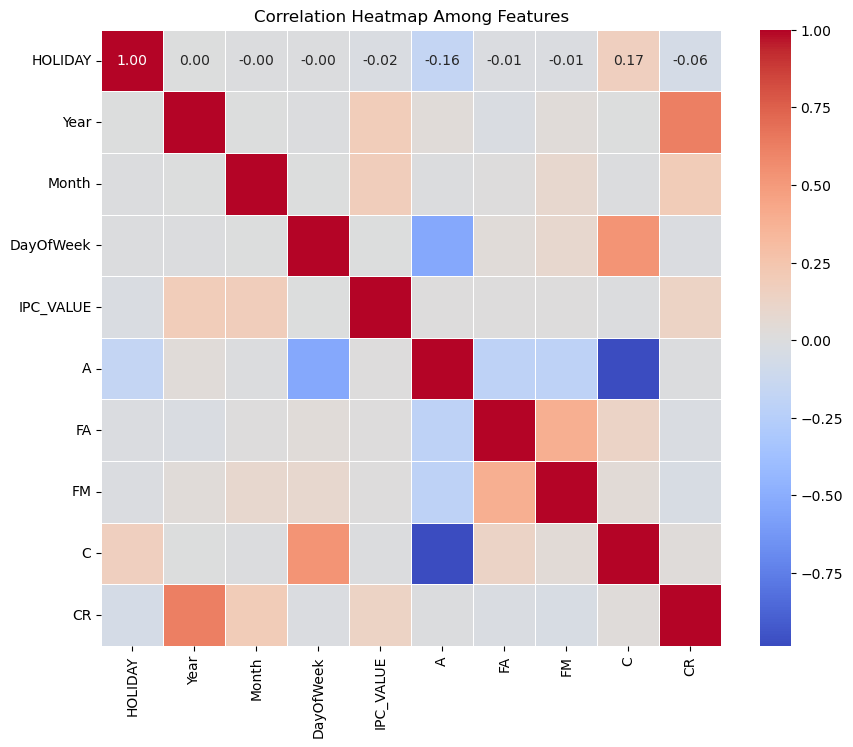

In [36]:
correlation_matrix = sales_df[numeric_features].corr()

# Plot a heatmap of the correlation matrix with numbers in all cells
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlation Heatmap Among Features')
plt.show()

# Identify highly correlated pairs (absolute value > 0.8)
highly_correlated = correlation_matrix.abs() > 0.8
highly_correlated_pairs = correlation_matrix[highly_correlated & (correlation_matrix != 1)]

#print("Highly Correlated Pairs:")
#print(highly_correlated_pairs)

As anticipated, the heatmap reveals a strong negative correlation between `A` (open stores) and `C` (closed stores), which makes sense given that these features represent mutually exclusive states. 

When a feature is constant or exhibits minimal variance, its correlation with other features will often result in `NaN` values. This occurs because correlation is undefined for variables with zero or near-zero variance. This is likely the cause of the `NaN` values observed when examining the `highly_correlated_pairs`, as some features may have little or no variability in the dataset. Addressing these features, such as by removing or transforming them, could resolve the issue.

## 3. 🤖 Modeling

In this section you will declare everything you need to train your model and fit it to your dataset.

## 4. ✅ Validation

Decide what metric to use to validate the performance of your model and explain why you chose it.

## 5. 📊 Presentation of Results

If you find it interesting, you can use plots to explain your results, metrics and how your model performance degrades over time.

Also, it may be interesting to write down future work that you think may improve the obtained result.

### 5.1 👨🏻‍🏫 Explainability with SHAP

You have explained the results of your trained model using plots and your own words. Now... let's take the next step. We'll be using a library called SHAP, that may help you find insights and explainability on how your model learned the data.

If you haven't heard of SHAP you can find their web site here:

https://shap.readthedocs.io/en/latest/

Don't worry, you will be guided through this exercises.

#### 5.1.1 🐝 Build a Beeswarm plot

Build a Beeswarm plot to help you explain how each feature affects to the output given by the model

#### 5.1.2 💪🏻 Build a Force plot

Build a Force plot to help you explain how each feature affects to the output given by the model

#### 5.1.3 🤷🏻‍♂️ Optional

Explore the SHAP documentation and add any plot you may find useful to explain how the model decides its outputs.

## 6. 🗃️ Model export

If you have arrived to this point... Congratulations!! 🥳. You trained a working model that can now be served in an API to be used to make predictions.

If you feel like developing a simple REST API to serve your amazing model, continue to the next step you will find in the `app/main.py` file located in this repository.

But first, make sure to export your model to a file you can use to load it in your endpoint.